### Apply late fusion strategy with a adaptive non-linear classifier on the output probability of each modality.

In [2]:
import os
import numpy as np
from os import listdir
from os.path import isfile, join
import pandas as pd
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import json
import numpy as np
import itertools as it
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_predict

In [27]:
# read and threshold output.
# if less or eq to 7 put 0 (not depressed)
# else put 1 

DATA_PATH = "TemporalData60"
DATA_PATH2 = "FINAL_RESULTS_60"
onlyfiles = [f for f in listdir(DATA_PATH) if isfile(join(DATA_PATH, f))]
y = list()

for i in range(len(onlyfiles)):
    tmp =  np.load(os.path.join(DATA_PATH, onlyfiles[i]))
    label = tmp[0,0,-1]
    if (label <= 7):
        y.append(0)
    else:
        y.append(1)
        
print (len(y))


64


In [28]:
#read best models and compute probabilities
fidget_path = "FINAL_RESULTS_10/fidget_timesteps10_HiddenRatio0.4/"
fidget_train = np.load(os.path.join(fidget_path, 'X_train_tree_32_100.npy'))

clf = RandomForestClassifier() 
fidget_prob = cross_val_predict(clf, fidget_train, y, cv=3, method='predict_proba')
fidget_predictions = cross_val_predict(clf, fidget_train, y, cv=3)


au_path = "FINAL_RESULTS_60/au_timesteps60_HiddenRatio0.4/"
au_train = np.load(os.path.join(au_path, 'X_train_tree_32_50.npy'))

clf = RandomForestClassifier() 
au_prob = cross_val_predict(clf, au_train, y, cv=3, method='predict_proba')
au_predictions = cross_val_predict(clf, au_train, y, cv=3)

gaze_path = "FINAL_RESULTS_30/gaze_timesteps30_HiddenRatio0.4/"
gaze_train = np.load(os.path.join(gaze_path, 'X_train_tree_32_50.npy'))

clf = RandomForestClassifier() 
gaze_prob = cross_val_predict(clf, gaze_train, y, cv=3, method='predict_proba')
gaze_predictions = cross_val_predict(clf, gaze_train, y, cv=3)


mfcc_path = "FINAL_RESULTS_60/mfcc_timesteps60_HiddenRatio0.4/"
mfcc_train = np.load(os.path.join(mfcc_path, 'X_train_tree_32_50.npy'))

clf = RandomForestClassifier() 
mfcc_prob = cross_val_predict(clf, mfcc_train, y, cv=3, method='predict_proba')
mfcc_predictions = cross_val_predict(clf, mfcc_train, y, cv=3)



In [29]:
correct_fidget = list()
for i in range(len(y)):
    if (fidget_predictions[i]==y[i]):
        correct_fidget.append(i)
        
correct_au = list()
for i in range(len(y)):
    if (au_predictions[i]==y[i]):
        correct_au.append(i)
        
correct_gaze = list()
for i in range(len(y)):
    if (gaze_predictions[i]==y[i]):
        correct_gaze.append(i)
        
correct_mfcc = list()
for i in range(len(y)):
    if (mfcc_predictions[i]==y[i]):
        correct_mfcc.append(i)
        

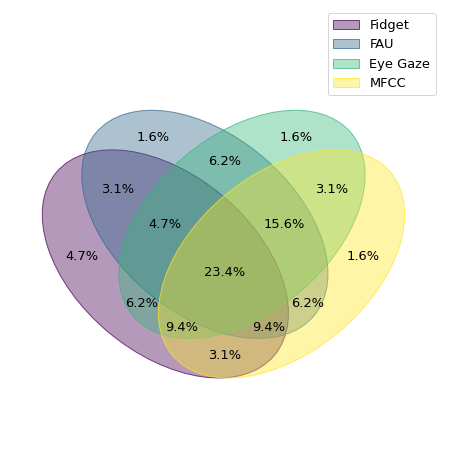

In [42]:
from venn import venn

musicians = {
    "Fidget": set(correct_fidget),
    "FAU": set(correct_au),
    "Eye Gaze": set(correct_gaze),
    "MFCC": set(correct_mfcc)
    
}
venn(musicians,fmt="{percentage:.1f}%")




In [31]:
sets = ['fidget', 'au', 'gaze', 'mfcc']

In [32]:
mean_voting = 0
max_voting = np.zeros((64,2))
x_train = list()
x_dev = list()

for i in range(len(sets)):
    if sets[i] == 'fidget':
        mean_voting += fidget_prob
        x_train.append(fidget_prob)
        for i in range(len(fidget_predictions)):
            if (fidget_predictions[i]==0):
                max_voting[i][0] += 1
            elif (fidget_predictions[i]==1):
                max_voting[i][1] += 1
            
                
    elif sets[i] == 'au':
        mean_voting += au_prob
        x_train.append(au_prob)
        for i in range(len(au_predictions)):
            if (au_predictions[i]==0):
                max_voting[i][0] += 1
            elif (au_predictions[i]==1):
                max_voting[i][1] += 1
           
                
    elif sets[i] == 'gaze':
        mean_voting += gaze_prob
        x_train.append(gaze_prob)
        for i in range(len(gaze_predictions)):
            if (gaze_predictions[i]==0):
                max_voting[i][0] += 1
            elif (gaze_predictions[i]==1):
                max_voting[i][1] += 1
            
                
    elif sets[i] == 'mfcc':
        mean_voting += mfcc_prob
        x_train.append(mfcc_prob)
        for i in range(len(mfcc_predictions)):
            if (mfcc_predictions[i]==0):
                max_voting[i][0] += 1
            elif (mfcc_predictions[i]==1):
                max_voting[i][1] += 1
            
       
        
mean_voting = mean_voting/len(sets)  
f1 = np.argmax(mean_voting, axis=-1)
print ("Mean voting")
print ("------"*10)
precision, recall, fscore, _ = precision_recall_fscore_support(list(y), f1, average='macro')
print("\naccuracy on development set: %.4f" % metrics.accuracy_score(f1, list(y)))
print("\nprecision on dev set: %.4f" % precision)
print("\nrecall on dev set: %.4f" % recall)
print("\nfscore on dev set: %.4f" % fscore)
print ("------"*10)

print ("\n")

print ("Max voting")
f_pred1 = np.argmax(max_voting, axis=-1)
precision, recall, fscore, _ = precision_recall_fscore_support(list(y), f_pred1, average='macro')
print("\naccuracy on development set: %.4f" % metrics.accuracy_score(f_pred1, list(y)))
print("\nprecision on dev set: %.4f" % precision)
print("\nrecall on dev set: %.4f" % recall)
print("\nfscore on dev set: %.4f" % fscore)

x_train = np.hstack((x_train))
x_train.shape

Mean voting
------------------------------------------------------------

accuracy on development set: 0.8438

precision on dev set: 0.8438

recall on dev set: 0.8451

fscore on dev set: 0.8436
------------------------------------------------------------


Max voting

accuracy on development set: 0.7812

precision on dev set: 0.7976

recall on dev set: 0.7882

fscore on dev set: 0.7804


(64, 8)

In [34]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from keras.utils import to_categorical

kfold = StratifiedKFold(n_splits=3, shuffle=True)
f1scores = []
accscores = []
recallscores = []
precscores = []
for train, test in kfold.split(x_train, y):
    
   # create model
    model = Sequential()
    model.add(Dense(4, input_dim=8, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    y = np.array(y)
    y_train = y[train]
    y_test = y[test]
    y_train_keras = to_categorical(y_train)
    y_test_keras = to_categorical(y_test)
    
    model.fit(x_train[train], y_train_keras, epochs=500, batch_size=2, verbose=0)
    tmp = model.predict_classes(x_train[test])
    precision, recall, fscore, _ = precision_recall_fscore_support(list(y_test), tmp, average='binary')
    scores = model.evaluate(x_train[test], y_test_keras, verbose=0)[1]
    f1scores.append(fscore)
    precscores.append(precision)
    recallscores.append(recall)
    accscores.append(scores)
    
print("Mean F1 score", np.mean(f1scores))
print("Mean recall score", np.mean(recallscores))
print("Mean acc score", np.mean(accscores))
print("Mean prec score", np.mean(precscores))

Mean F1 score 0.870663153271849
Mean recall score 0.8838383838383838
Mean acc score 0.8585858742396036
Mean prec score 0.8675213675213675


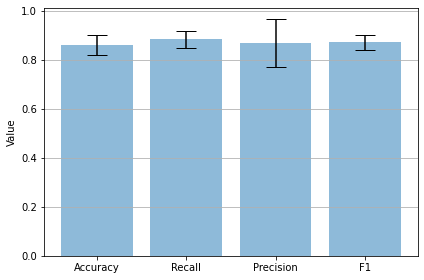

In [37]:
import matplotlib.pyplot as plt
mean_acc = np.mean(accscores)
mean_rec = np.mean(recallscores)
mean_pre = np.mean(precscores)
mean_f1  = np.mean(f1scores)

acc_std = np.std(accscores)
rec_std = np.std(recallscores)
pre_std = np.std(precscores)
f1_std = np.std(f1scores)

materials = ['Accuracy', 'Recall', 'Precision', 'F1']
x_pos = np.arange(len(materials))
metrics = [mean_acc, mean_rec, mean_pre, mean_f1]
error = [acc_std, rec_std, pre_std, f1_std]

fig, ax = plt.subplots()
ax.bar(x_pos, metrics, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Value')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()